In [1]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
import matplotlib.pyplot as plt
import pickle
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_linnerud
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.multioutput import RegressorChain
from sklearn.model_selection import train_test_split
from skimage import io
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

In [2]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy


    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [3]:
file = [Path(f).stem for f in glob.glob(r"C:/Users/User/Downloads/ml project media pipe/AFLW2000/*.mat")]

In [4]:
path = r"C:/Users/User/Downloads/ml project media pipe/AFLW2000"
paths = []
for i in range(len(file)):
    mat_path = os.path.join(path,file[i] + ".mat")
    paths.append(mat_path)

paths


['C:/Users/User/Downloads/ml project media pipe/AFLW2000\\image00002.mat',
 'C:/Users/User/Downloads/ml project media pipe/AFLW2000\\image00004.mat',
 'C:/Users/User/Downloads/ml project media pipe/AFLW2000\\image00006.mat',
 'C:/Users/User/Downloads/ml project media pipe/AFLW2000\\image00008.mat',
 'C:/Users/User/Downloads/ml project media pipe/AFLW2000\\image00010.mat',
 'C:/Users/User/Downloads/ml project media pipe/AFLW2000\\image00013.mat',
 'C:/Users/User/Downloads/ml project media pipe/AFLW2000\\image00014.mat',
 'C:/Users/User/Downloads/ml project media pipe/AFLW2000\\image00019.mat',
 'C:/Users/User/Downloads/ml project media pipe/AFLW2000\\image00020.mat',
 'C:/Users/User/Downloads/ml project media pipe/AFLW2000\\image00021.mat',
 'C:/Users/User/Downloads/ml project media pipe/AFLW2000\\image00022.mat',
 'C:/Users/User/Downloads/ml project media pipe/AFLW2000\\image00023.mat',
 'C:/Users/User/Downloads/ml project media pipe/AFLW2000\\image00026.mat',
 'C:/Users/User/Downloads

In [5]:
def yawpitchroll_mat(mat_path):
    mat = sio.loadmat(mat_path)
    pre_pose_params = mat['Pose_Para'][0]
    pose_params = pre_pose_params[:3]
    return pose_params

yawpitchroll = []
for index in range(len(paths)):
    yawpitchroll.append(yawpitchroll_mat(paths[index]))

yawpitchroll_df = pd.DataFrame(yawpitchroll,columns=["yaw","pitch","roll"])
yawpitchroll_df['img'] = file
yawpitchroll_df

,yaw,pitch,roll,img
0,-0.399231,0.018227,0.085676,image00002
1,0.470065,1.189533,0.300959,image00004
2,-0.184650,0.881137,-0.236852,image00006
3,-0.175379,0.299208,-0.373374,image00008
4,-0.882169,1.198004,-1.033374,image00010
...,...,...,...,...
1995,-0.197102,-0.070430,0.105118,image04358
1996,-0.232617,-1.418751,0.175960,image04363
1997,-1.447955,1.431267,-1.509418,image04364
1998,-0.420465,-1.191176,0.451515,image04365


In [6]:
x_relative = []
y_relative = []
img = []
for iter in file:
    faceModule = mediapipe.solutions.face_mesh
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        image = io.imread(r'C:/Users/User/Downloads/ml project media pipe/AFLW2000/'+iter+'.jpg')
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
            for face in results.multi_face_landmarks:
                lst1 = []
                lst2 = []
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
                    lst1.append(relative_x)
                    lst2.append(relative_y)

                x_relative.append(lst1)
                y_relative.append(lst2)
                img.append(iter)

In [7]:
xdf = pd.DataFrame(x_relative)
ydf = pd.DataFrame(y_relative)
img_df = pd.DataFrame(img , columns=['img'])

In [8]:
concatenated_dfs = pd.concat([xdf, ydf,img_df], axis="columns")

In [9]:
concatenated_dfs

,0,1,2,3,4,5,6,7,8,9,...,459,460,461,462,463,464,465,466,467,img
0,221,221,222,216,222,223,227,163,230,230,...,290,288,294,293,217,221,225,211,206,image00002
1,211,195,208,196,193,195,204,188,205,203,...,275,277,278,279,232,235,237,229,224,image00006
2,226,211,220,200,207,205,204,163,198,194,...,288,284,293,293,225,230,233,205,200,image00008
3,229,221,224,208,218,216,212,158,208,206,...,268,272,273,275,217,220,221,203,201,image00013
4,221,215,219,209,215,215,218,167,218,218,...,264,272,268,271,220,221,222,215,211,image00014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,195,179,195,184,178,181,194,192,195,192,...,269,272,273,274,223,226,229,214,211,image04334
1636,234,251,237,236,253,249,237,143,234,235,...,282,283,288,289,214,218,221,205,198,image04342
1637,231,235,232,224,235,234,231,156,230,231,...,280,284,284,285,224,227,229,221,218,image04344
1638,234,243,235,232,244,242,235,160,233,234,...,283,283,287,288,224,227,230,216,213,image04345


In [10]:
df=concatenated_dfs.join(yawpitchroll_df.set_index('img'), on='img')

In [11]:
df.to_csv("data",index=False)

In [12]:
data = pd.read_csv(r"C:/Users/User/Downloads/ml project media pipe/AFLW2000/data")
data

,0,1,2,3,4,5,6,7,8,9,...,462.1,463.1,464.1,465.1,466.1,467.1,img,yaw,pitch,roll
0,221,221,222,216,222,223,227,163,230,230,...,293,217,221,225,211,206,image00002,-0.399231,0.018227,0.085676
1,211,195,208,196,193,195,204,188,205,203,...,279,232,235,237,229,224,image00006,-0.184650,0.881137,-0.236852
2,226,211,220,200,207,205,204,163,198,194,...,293,225,230,233,205,200,image00008,-0.175379,0.299208,-0.373374
3,229,221,224,208,218,216,212,158,208,206,...,275,217,220,221,203,201,image00013,-0.026812,0.011965,-0.220662
4,221,215,219,209,215,215,218,167,218,218,...,271,220,221,222,215,211,image00014,0.057119,0.110732,-0.043283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,195,179,195,184,178,181,194,192,195,192,...,274,223,226,229,214,211,image04334,-0.202474,1.198175,-0.352237
1636,234,251,237,236,253,249,237,143,234,235,...,289,214,218,221,205,198,image04342,-0.482186,-0.389773,0.056335
1637,231,235,232,224,235,234,231,156,230,231,...,285,224,227,229,221,218,image04344,-0.173351,-0.060273,0.000774
1638,234,243,235,232,244,242,235,160,233,234,...,288,224,227,230,216,213,image04345,-0.306358,-0.283822,0.038554


In [13]:
x= data.drop(['yaw'	,'pitch'	,'roll','img'],axis=1)
y= data[['yaw'	,'pitch'	,'roll']]

In [14]:
X_train, X_test, y_train, y_test= train_test_split(x, y, test_size=0.2, random_state=42)

In [15]:
regr = MultiOutputRegressor(SVR(C=3,epsilon=0.02,tol=0.00001))
pipe = Pipeline([('scaler', StandardScaler()),('pca',PCA(n_components=500)), ('svr', regr)])

In [16]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=500)),
                ('svr',
                 MultiOutputRegressor(estimator=SVR(C=3, epsilon=0.02,
                                                    tol=1e-05)))])

In [17]:
pipe.score(X_test, y_test)

0.8420659792554589

In [18]:
yd=pipe.predict(X_test)

In [19]:
print("R2 score: ", r2_score(y_test, yd))
print("MSE: ", mean_squared_error(y_test, yd))

R2 score:  0.8420659792554589
MSE:  0.01293798587541377


In [20]:
filename = 'model.sav'
pickle.dump(pipe, open(filename, 'wb'))

In [21]:
loaded_model = pickle.load(open(filename, 'rb'))


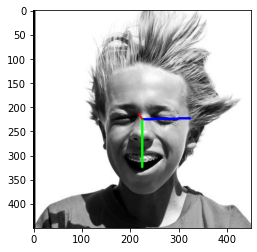

In [22]:
image = io.imread(r'C:/Users/User/Downloads/ml project media pipe/AFLW2000/'+'image00126'+'.jpg')
mat_file = sio.loadmat(r'C:/Users/User/Downloads/ml project media pipe/AFLW2000/'+'image00126'+'.mat')
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
plt.imshow(draw_axis(image,pitch,yaw,roll))

In [23]:
def getData(image,draw_mesh=False):
    faceModule = mediapipe.solutions.face_mesh
    x_relative = []
    y_relative = []
    images_data = []
    mesh_image = image.copy()

    with faceModule.FaceMesh(static_image_mode=True) as faces:
        image_data = []
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        if results.multi_face_landmarks != None:
            for face in results.multi_face_landmarks:
                lst1=[]
                lst2=[]
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    lst1.append(relative_x)
                    lst2.append(relative_y)
                    if draw_mesh:
                        cv2.circle(mesh_image, (relative_x, relative_y), radius=1, color=(0, 200, 0), thickness=2)
                    
                x_relative.append(lst1)
                y_relative.append(lst2)
     
    df1 = pd.DataFrame(x_relative)
    df2 = pd.DataFrame(y_relative)
    df =  pd.concat([df1,df2],axis="columns")
    cols = []
    cols += [x+str(i+1) for i in range(468) for x in ['X']]
    cols += [x+str(i+1) for i in range(468) for x in ['Y']]
    df.columns = cols
    return df, image, mesh_image

In [24]:
cols = []
cols += [x+str(i+1) for i in range(468) for x in ['X']]
cols += [x+str(i+1) for i in range(468) for x in ['Y']]

cols

['X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'X8',
 'X9',
 'X10',
 'X11',
 'X12',
 'X13',
 'X14',
 'X15',
 'X16',
 'X17',
 'X18',
 'X19',
 'X20',
 'X21',
 'X22',
 'X23',
 'X24',
 'X25',
 'X26',
 'X27',
 'X28',
 'X29',
 'X30',
 'X31',
 'X32',
 'X33',
 'X34',
 'X35',
 'X36',
 'X37',
 'X38',
 'X39',
 'X40',
 'X41',
 'X42',
 'X43',
 'X44',
 'X45',
 'X46',
 'X47',
 'X48',
 'X49',
 'X50',
 'X51',
 'X52',
 'X53',
 'X54',
 'X55',
 'X56',
 'X57',
 'X58',
 'X59',
 'X60',
 'X61',
 'X62',
 'X63',
 'X64',
 'X65',
 'X66',
 'X67',
 'X68',
 'X69',
 'X70',
 'X71',
 'X72',
 'X73',
 'X74',
 'X75',
 'X76',
 'X77',
 'X78',
 'X79',
 'X80',
 'X81',
 'X82',
 'X83',
 'X84',
 'X85',
 'X86',
 'X87',
 'X88',
 'X89',
 'X90',
 'X91',
 'X92',
 'X93',
 'X94',
 'X95',
 'X96',
 'X97',
 'X98',
 'X99',
 'X100',
 'X101',
 'X102',
 'X103',
 'X104',
 'X105',
 'X106',
 'X107',
 'X108',
 'X109',
 'X110',
 'X111',
 'X112',
 'X113',
 'X114',
 'X115',
 'X116',
 'X117',
 'X118',
 'X119',
 'X120',
 'X121',
 'X122',
 'X123',
 

In [25]:
def functionality(frame):
    df_frame, frame,frame_mesh = getData(frame, draw_mesh=False)
    if df_frame.size > 0:
        df_frame, image, mesh = getData(frame)
        y_pred = pipe.predict(df_frame)[0]
        pitch = y_pred[0]
        yaw = y_pred[1]
        roll = y_pred[2]
        tdx = int(df_frame['X3'].values)
        tdy = int(df_frame['Y3'].values)
        print(y_pred)
        return draw_axis(frame_mesh,pitch,yaw,roll, tdx=tdx, tdy=tdy, size=50)
    else:
        return frame
    


In [26]:
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:
    c = cv2.waitKey(1) 
    ret, frame = cap.read()
    
    if frame is not None and ret:
            frame = functionality(frame)

    
    frame = cv2.resize(frame, None, fx=1, fy=1, interpolation=cv2.INTER_AREA)

    cv2.imshow('Pose Detection Application', frame)
    
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()

[ 0.03606501  0.11824911 -0.11834492]
[ 0.03608401  0.11847331 -0.11830702]
[ 0.03588901  0.11554056 -0.11879664]
[ 0.03571332  0.10955923 -0.11994405]
[ 0.03579836  0.11527283 -0.11879026]
[ 0.03568542  0.11553227 -0.11867468]
[ 0.03557732  0.12061422 -0.11752551]
[ 0.03556949  0.12246546 -0.11712849]
[ 0.03557052  0.12264776 -0.11709084]
[ 0.03557041  0.12269145 -0.11708153]
[ 0.03558293  0.12185334 -0.1172684 ]
[ 0.03568901  0.1126177  -0.11929079]
[ 0.0355809   0.11336357 -0.11904176]
[ 0.03556549  0.12098214 -0.11743637]
[ 0.03556622  0.12244053 -0.11713   ]
[ 0.03554735  0.12217844 -0.11715879]
[ 0.03560523  0.11909485 -0.11779134]
[ 0.0360241   0.11936746 -0.11806687]
[ 0.03616757  0.12138256 -0.11777735]
[ 0.03606033  0.11977823 -0.11803305]
[ 0.03611762  0.11975613 -0.1180592 ]
[ 0.03604387  0.11896299 -0.11816574]
[ 0.03593723  0.117811   -0.11834105]
[ 0.03594716  0.11802026 -0.11829705]
[ 0.03592343  0.11766259 -0.1183556 ]
[ 0.03591735  0.11759776 -0.11836689]
[ 0.03592021

KeyboardInterrupt: 